In [83]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time


import torchvision
from torchvision import transforms
import torchvision.models as models
from ptflops import get_model_complexity_info

import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((64,64))])

batch_size = 80

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [44]:
def training(train_loader,test_loader,model,opti,name,num_epoch,lrr=0.0001,wd=0,save_model=0,m=0.9,py1 = 1,py2=28,py3=28):
    t0 = time.time()
    if opti =="CEL":
        criterion = nn.CrossEntropyLoss()
    elif opti =="BCE":
        criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(),lr=lrr,weight_decay = wd, momentum=m)
    
    loss_train_array = torch.zeros(num_epoch)
    acc_training_array = torch.zeros(num_epoch)
    acc_array = torch.zeros(num_epoch)
    
    i=0
    for epoch in range(num_epoch):
        correct_t = 0
        total_t = 60000
        for imgs, labels in train_loader:
            imgs,labels = imgs.to(device),labels.to(device)
            batch_size = imgs.shape[0] #takes image data, puts into 0 x data tensor
            outputs = model(imgs)
            #outputs = model(imgs.view(batch_size, -1)) unsqueeze(0) adds dimensionality at dimension 0, (0,1)--> (0,1,2) where 1 is the new dimension
            loss = criterion(outputs,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            for imgss, labelss in train_loader:
                imgss,labelss = imgss.to(device),labelss.to(device)
                batch_size = imgss.shape[0] # records size of imgs.shape[0]
                outputss = model(imgss)
                
                #outputss = model(imgss.view(batch_size,-1))
                _,predictedd = torch.max(outputss,dim=1) #
               # total_t += labels.shape[0] #create 
                correct_t += int((predictedd == labelss).sum()) # if predicted is the answer, add it to sum
            #print(correct_t)
            #print(total_t)

        print(" Epoch: %d, Loss: %F" % (epoch, float(loss)))
        print("Training Accuracy: %f" % (correct_t / total_t))
        loss_train_array[i]=float(loss)
        acc_training_array[i]=float(correct_t/total_t)
        
        correct_v = 0
        total_v = 10000
        #val_loss_v = 0
        
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs,labels = imgs.to(device),labels.to(device)
                batch_size = imgs.shape[0] # records size of imgs.shape[0]
                outputs = model(imgs)
                #outputs = model(imgs.view(batch_size,-1)) #predicts output class with model, .view changes shape to be batchsize (1D array)
                _,predicted = torch.max(outputs,dim=1) #
               # total_v += labels.shape[0] #create 
                correct_v += int((predicted == labels).sum()) # if predicted is the answer, add it to sum
        #print(correct_v)
        #print(total_v)
        print("Validation Accuracy: ", correct_v / total_v)
        acc_array[i] = correct_v / total_v
        i = i+1
    print(f'training time = {time.time()-t0}')
    plt.plot(range(num_epoch),loss_train_array,color = 'blue',label ='Training Loss')
    plt.plot(range(num_epoch),acc_training_array,color = 'red',label ='Training Accuracy')
    plt.plot(range(num_epoch),acc_array,color = 'green',label ='Validation Accuracy')
    plt.title(f'Cifar10')
    plt.xlabel('epoch')
    plt.ylabel('Value')
    with torch.cuda.device(0):
        net = model
        macs, params = get_model_complexity_info(net, ( py1, py2, py3), as_strings=True,
                                           print_per_layer_stat=True, verbose=True) # 3,64,64 is res of each image
        print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
        print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    if save_model == 1:
        torch.save(model.state_dict(), name)

In [9]:
'''def vgg_block(num_convs,out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3,padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)
'''




class VGG(nn.Module):
    def __init__(self,arch,in_channels=3):
        super().__init__()
        self.in_channels = in_channels
        self.architecture =arch
        self.conv = self.init_convs(arch)
        self.M = nn.MaxPool2d(kernel_size=2,stride=2)
        self.L1 = nn.Linear(2048,4096)
        self.L2 = nn.Linear(4096,4096)
        self.out = nn.Linear(4096,10)
        
        self.flat = nn.Flatten()
        self.S = nn.Softmax()
        self.R = nn.ReLU()
        
        self.drop1 = nn.Dropout(0.3)
        self.drop2 = nn.Dropout(0.3)
        
        
    def init_convs(self,architecture):
        layers = []
        i=0
        for(num_convs, out_channels) in self.architecture:
            i=0
            while i<num_convs:
                layers.extend([nn.Conv2d(self.in_channels,out_channels,kernel_size=3,padding=1),nn.BatchNorm2d(out_channels),nn.ReLU()])
                self.in_channels = out_channels
                i += 1
            layers.append( nn.MaxPool2d(kernel_size=2,stride=2))
            
        return nn.Sequential(*layers)
    def forward(self,x):
        x = self.conv(x)
        x = self.flat(x)
        x = self.R(self.L1(x))
        x = self.drop1(x)
        x = self.R(self.L2(x))
        x = self.drop2(x)
        x = self.S(self.out(x))
        return x
VGG11 = VGG(arch = ((1,64), (1,128), (2,256), (2,512),(2,512)))
VGG16 = VGG(arch = ((2,64),(2,128),(3,256),(3,512),(3,512)))
VGG19 = VGG(arch = ((2,64),(2,128),(4,256),(4,512),(4,512)))


C:\Users\matth\AppData\Local\Temp\ipykernel_23568\990339595.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.S(self.out(x))


 Epoch: 0, Loss: 2.011378
Training Accuracy: 0.470283
Validation Accuracy:  0.5582
 Epoch: 1, Loss: 1.761146
Training Accuracy: 0.557517
Validation Accuracy:  0.6532
 Epoch: 2, Loss: 1.784409
Training Accuracy: 0.586700
Validation Accuracy:  0.6823
 Epoch: 3, Loss: 1.736863
Training Accuracy: 0.617450
Validation Accuracy:  0.7157
 Epoch: 4, Loss: 1.710851
Training Accuracy: 0.630467
Validation Accuracy:  0.7227
 Epoch: 5, Loss: 1.671537
Training Accuracy: 0.651467
Validation Accuracy:  0.7514
 Epoch: 6, Loss: 1.689944
Training Accuracy: 0.651083
Validation Accuracy:  0.7443
 Epoch: 7, Loss: 1.684208
Training Accuracy: 0.663967
Validation Accuracy:  0.7576
 Epoch: 8, Loss: 1.655946
Training Accuracy: 0.683650
Validation Accuracy:  0.7808
 Epoch: 9, Loss: 1.648230
Training Accuracy: 0.689267
Validation Accuracy:  0.7824
training time = 445.60256838798523
VGG(
  34.44 M, 100.000% Params, 639.21 MMac, 100.000% MACs, 
  (conv): Sequential(
    9.23 M, 26.788% Params, 613.98 MMac, 96.054% MA

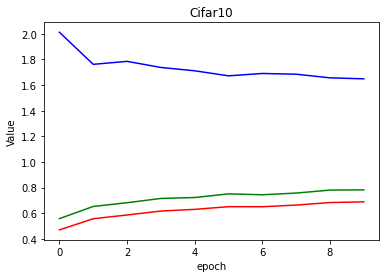

In [10]:
VGG11.to(device)
training(trainloader,testloader,VGG11,"CEL","P1_model",10,0.01,0.0001,1,0.9,3,64,64)

C:\Users\matth\AppData\Local\Temp\ipykernel_23568\990339595.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.S(self.out(x))


 Epoch: 0, Loss: 1.764961
Training Accuracy: 0.549133
Validation Accuracy:  0.6385
 Epoch: 1, Loss: 1.757689
Training Accuracy: 0.589850
Validation Accuracy:  0.6904
 Epoch: 2, Loss: 1.745397
Training Accuracy: 0.624683
Validation Accuracy:  0.7249
 Epoch: 3, Loss: 1.640039
Training Accuracy: 0.635050
Validation Accuracy:  0.7316
 Epoch: 4, Loss: 1.710054
Training Accuracy: 0.644183
Validation Accuracy:  0.7458
 Epoch: 5, Loss: 1.608147
Training Accuracy: 0.643250
Validation Accuracy:  0.7449
 Epoch: 6, Loss: 1.689673
Training Accuracy: 0.669417
Validation Accuracy:  0.7697
 Epoch: 7, Loss: 1.731080
Training Accuracy: 0.675483
Validation Accuracy:  0.7775
 Epoch: 8, Loss: 1.722731
Training Accuracy: 0.684267
Validation Accuracy:  0.7856
 Epoch: 9, Loss: 1.648384
Training Accuracy: 0.685200
Validation Accuracy:  0.778
training time = 713.1725594997406
VGG(
  39.94 M, 100.000% Params, 1.28 GMac, 100.000% MACs, 
  (conv): Sequential(
    14.72 M, 36.865% Params, 1.26 GMac, 98.034% MACs, 


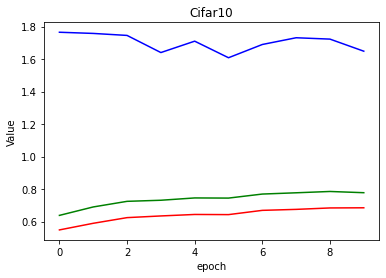

In [12]:
VGG16.to(device)
training(trainloader,testloader,VGG16,"CEL","P1.2_model",10,0.01,0.0001,1,0.9,3,64,64)

In [112]:
class Inception(nn.Module):
    def __init__(self,c1,c2,c3,c4):
        super(Inception,self).__init__()
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        
        
        self.b2_1 = nn.LazyConv2d(c2[0],kernel_size=1)
        
        
        self.b2_2 = nn.LazyConv2d(c2[1],kernel_size=3,padding=1)
       
        self.b3_1 = nn.LazyConv2d(c3[0],kernel_size=1)
        
        self.b3_2 = nn.LazyConv2d(c3[1],kernel_size=5,padding=2)
        
        
        self.b4_1 = nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.b4_2 = nn.LazyConv2d(c4,kernel_size=1)
        
    def forward(self,x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1,b2,b3,b4),dim=1)
    
    
class GoogleNet(nn.Module):
    def __init__(self):
        super(GoogleNet,self).__init__()
        
        self.gnet = nn.Sequential(self.b1(),self.b2(),self.b3(),self.b4(),self.b5(),nn.LazyLinear(10))
        
    def b1(self):
        y = nn.Sequential(nn.Conv2d(3,64,kernel_size = 7,stride = 2,padding = 3),nn.BatchNorm2d(64),nn.ReLU(),nn.MaxPool2d(kernel_size=3,stride=2,padding=1))
        y.to(device)
        return y
    
    def b2(self):
        y =  nn.Sequential(nn.Conv2d(64,64,kernel_size=1),nn.ReLU(),nn.Conv2d(64,192,kernel_size=3, padding=1),nn.BatchNorm2d(192),nn.ReLU(),nn.MaxPool2d(kernel_size=3,stride=2,padding=1))
        y.to(device)
        return y
    
    def b3(self):
        return nn.Sequential(Inception(64,(96,128),(16,32),32),Inception(128,(128,192),(32,96),64),nn.MaxPool2d(kernel_size=3,stride=2,padding=1))
    
    def b4(self):
        return nn.Sequential(Inception(192,(96,208),(16,48),64),Inception(160,(112,224),(24,64),64),Inception(128,(128,256),(24,64),64),Inception(112,(144,228),(32,64),64),nn.MaxPool2d(kernel_size=3,stride=2,padding=1))
   
    def b5(self):
        return nn.Sequential(Inception(256,(160,320),(32,128),128),Inception(384,(192,384),(48,128),128),nn.BatchNorm2d(1024),nn.AdaptiveAvgPool2d((1,1)),nn.Flatten())
    
    def forward(self,x):
        x = x.to(device)
        return self.gnet(x)
google = GoogleNet()
google.to(device)

GoogleNet(
  (gnet): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Inception(
        (b1_1): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
        (b2_1): LazyConv2d(0, 96, kernel_size=(1, 1), stride=(1, 1))
        (b2_2): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (b3_1): LazyCo

 Epoch: 0, Loss: 1.136280
Training Accuracy: 0.487850
Validation Accuracy:  0.5815
 Epoch: 1, Loss: 0.961321
Training Accuracy: 0.587017
Validation Accuracy:  0.6941
 Epoch: 2, Loss: 0.698962
Training Accuracy: 0.639717
Validation Accuracy:  0.7356
 Epoch: 3, Loss: 0.426163
Training Accuracy: 0.673083
Validation Accuracy:  0.7659
 Epoch: 4, Loss: 0.629263
Training Accuracy: 0.695600
Validation Accuracy:  0.7902
 Epoch: 5, Loss: 0.402900
Training Accuracy: 0.714517
Validation Accuracy:  0.7903
 Epoch: 6, Loss: 0.676019
Training Accuracy: 0.731000
Validation Accuracy:  0.8062
 Epoch: 7, Loss: 0.397251
Training Accuracy: 0.737533
Validation Accuracy:  0.8037
 Epoch: 8, Loss: 0.350113
Training Accuracy: 0.754250
Validation Accuracy:  0.8098
 Epoch: 9, Loss: 0.458623
Training Accuracy: 0.748750
Validation Accuracy:  0.8011
training time = 353.1217050552368


ValueError: Attempted to use an uninitialized parameter in <method 'numel' of 'torch._C._TensorBase' objects>. This error happens when you are using a `LazyModule` or explicitly manipulating `torch.nn.parameter.UninitializedParameter` objects. When using LazyModules Call `forward` with a dummy batch to initialize the parameters before calling torch functions

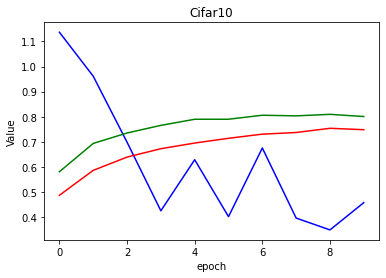

In [113]:
training(trainloader,testloader,google,"CEL","P2.1_model",10,0.01,0.0001,1,0.9,3,64,64)